# Защита персональных данных клиентов

Страховой компании необходимо защитить данные клиентов, которые подаются на вход модели машинного обучения. Задача - разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию (с обоснованием корректности его работы). В то же время при преобразовании качество модели не должно ухудшаться. Подбирать наилучшую модель не требуется.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-обзор" data-toc-modified-id="Предварительный-обзор-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный обзор</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Теоретический-раздел" data-toc-modified-id="Теоретический-раздел-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Теоретический раздел</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span><ul class="toc-item"><li><span><a href="#Рекомендации-по-заполнению-данных" data-toc-modified-id="Рекомендации-по-заполнению-данных-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Рекомендации по заполнению данных</a></span></li></ul></li></ul></div>

## Обзор и предобработка данных

In [1]:
# Импортируем необходимые модули:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_spd_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
# Зафиксируем состояние генератора случайных чисел для воспроизведения результатов:
random_state = 177013

### Предварительный обзор

Ознакомимся с первыми строками таблицы, небольшой случайной выборкой из нее и общей информацией:

In [3]:
df = pd.read_csv ('/datasets/insurance.csv')

In [4]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df.sample(n=10, random_state=random_state)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
3284,0,18.0,29000.0,0,0
4850,0,19.0,42000.0,2,0
2783,0,39.0,57800.0,1,0
3828,0,32.0,32000.0,0,0
2459,0,26.0,32600.0,0,0
2358,1,31.0,48500.0,1,0
3706,1,38.0,37700.0,2,0
2126,0,32.0,42400.0,2,0
3181,1,25.0,51900.0,0,0
2926,1,23.0,42700.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


Предоставлены данные о 5000 клиентов по 5 признакам, все они числовые и выглядят целыми. Проверим целесообразность приведения столбцов `Возраст` и `Зарплата` к целочисленному типу:

In [8]:
len (df[df['Возраст'] - df['Возраст'].astype('int') != 0])

0

In [9]:
len(df[df['Зарплата'].round() % 100 !=0])

0

Действительно, для значения возраста не используется дробная часть, а зарплаты кратны 100, что делает использование дробной части избыточным. Это значит, что все столбцы могут быть приведены к одному из целочисленных подтипов.

In [10]:
def convert_to_uint32(df):
    return df.astype('uint32')

Заголовки столбцов не следуют общепринятой практике (используется кириллица с заглавными буквами). Это неплохо для аналитической части, но для работы с моделью мы переименуем их:

In [11]:
def rename_columns(df):
    try:
        return df.rename(columns = {'Пол': 'sex',
                                    'Возраст': 'age',
                                    'Зарплата': 'salary',
                                    'Члены семьи': 'num_relatives', 
                                    'Страховые выплаты': 'num_insurance_cases'})
    except:
        print('Проверьте заготовки столбцов!')
        return df

In [12]:
df.duplicated().sum()

153

У нас есть порядка 3% идентичных строк, однако поскольку идентификаторов пользователя нет, а число признаков невелико, это могут быть и совпадения, поэтому мы сохраним эти строки в выборке.

### EDA

Согласно выводу *describe()* выше, значения признаков лежат в разумных пределах и не имеют пропусков. Рассмотрим их немного повнимательней перед построением модели.

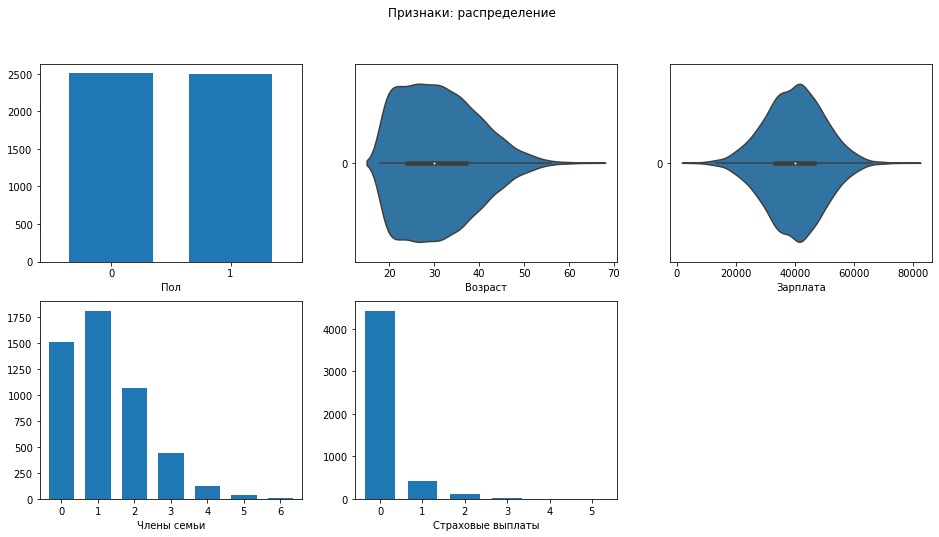

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
for column, ax in zip (df.columns, axes.flat):
    if df[column].nunique() < 10:
        df[column].value_counts().sort_index().plot(kind='bar', ax=ax, rot=0, width=0.7);
    else:
        sns.violinplot (data=df[column], ax=ax, orient='h');
    ax.set(xlabel=column)
axes[1,2].set_axis_off()        
fig.suptitle('Признаки: распределение');

- Распределение клиентов по **полу** практически сбалансировано, - хотя не документировано, как трактовать значения (традиционно для мужского пола применяют значение 1, но могут быть и исключения).
- **Возраст** большинства клиентов составляет от 18 до 37 лет, в среднем же 30-31 год. На людей от 37 до 65 приходится лишь 25% выборки.
- Распредедение **зарплат** клиентов близко к нормальному, среднее и медианное значение порядка 40 тыс. В целом разброс составляет от 5,3 тыс. до 79 тыс., половина значений приходится на диапазон 33,3 тыс. - 46,6 тыс.
- Количество **членов семьи** (по-видимому, не считая самого клиента, ввиду большого количества нулевых значений) колеблется в пределах 6, причем 75% значений не превышает 2, что соотносится со здравым смыслом.
- Число **страховых случаев** на клиента не превышает 5, причем подавляющее большинство (почти 4,5 тысячи из 5) таковых вовсе не имеет, а общая доля клиентов, получавших больше двух страховых выплат, не превышает 0,5%:

In [14]:
df['Страховые выплаты'].value_counts(normalize=True)

0    0.8872
1    0.0846
2    0.0230
3    0.0036
4    0.0014
5    0.0002
Name: Страховые выплаты, dtype: float64

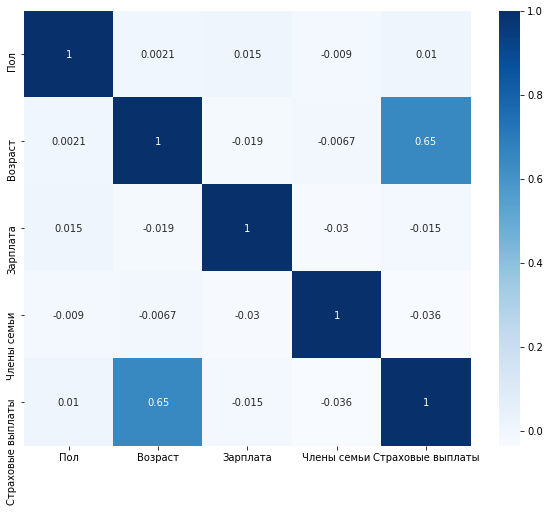

In [15]:
plt.figure (figsize=(10,8))
sns.heatmap (df.corr(), annot=True, cmap='Blues');

Что касается корреляций, число страховых случаев заметно коррелирует с возрастом, что в данном случае не тождественно корреляции со временем: оговорено, что страховые случаи для всех возрастов приведены за последние 5 лет. В остальном же линейной зависимости не наблюдается.

### Предобработка данных

Приведем столбцы к типу `uint32` и переименуем их:

In [16]:
df = (df.
      pipe(convert_to_uint32).
      pipe(rename_columns)
     )

In [17]:
df.sample(n=10, random_state=random_state)

,sex,age,salary,num_relatives,num_insurance_cases
3284,0,18,29000,0,0
4850,0,19,42000,2,0
2783,0,39,57800,1,0
3828,0,32,32000,0,0
2459,0,26,32600,0,0
2358,1,31,48500,1,0
3706,1,38,37700,2,0
2126,0,32,42400,2,0
3181,1,25,51900,0,0
2926,1,23,42700,0,0


### Вывод

Датасет содержит данные о 5000 клиентов по 5 признакам, все они числовые. Столбцы `Возраст` и `Зарплата` изначально используют тип с плавающей точкой, однако дробная часть не используется. В целях экономии ресурсов мы привели все столбцы к типу `uint32`.

Данные качественные, не имеют пропусков и распределены без аномалий. Часть строк являются полными дубликатами, однако при отсутсвии уникальных идентификаторов такие совпадения вполне возможны. Мультиколлинеарности признаков не отмечается.

Заголовки столбцов используют кириллицу с заглавными буквами. Следуя общепринятой практике, мы переименовали их по заключении аналитической части.

## Теоретический раздел

**Условные обозначения**

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

**Формулы линейной регрессии**

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Постановка задачи**:

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Краткий ответ:**

Не изменится.


**Обоснование:**

Пусть матрица $P$ - произвольная обратимая матрица, а результат умножения матрицы признаков на нее, соответственно, $XP$. Тогда новый вектор обучения (обозначим его как $w'$) можно вычислить как

$$w' = ((XP)^T XP)^{-1} (XP)^T y$$

По правилам транспонирования матриц, если существует произведение $XP$, то существует и $P^T X^T$, причем $P^T X^T = (XP)^T$:

$$ w' = (P^T X^T X P) ^{-1} P^T X^T y $$

Аналогичными свойствами обладает и обратная матрица произведения матриц, то есть:

$$ w' = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y $$

Произведение прямой и обратной матриц дает единичную матрицу, следовательно

$$ w' = P^{-1} (X^T X)^{-1} X^T y $$

Но так как по условию $w = (X^T X)^{-1} X^T y$, получается, что

$$ w' = P^{-1} w $$

И тогда новые предсказания (обозначим их как $a'$) $ a' = XPw' $ или $ XP P^{-1} w $, а следовательно $ a' = Xw = a $

Таким образом, **при умножении матрицы признаков на обратимую матрицу предсказания модели не изменятся**, а значит, не изменится и качество.

## Алгоритм преобразования

**Алгоритм**

Воспользуемся доказанным нами свойством линейной регрессии:

1. Сгенерируем случайную матрицу размером $n x n$, где $n$ - число признаков в обучающей выборке, и проверим ее на обратимость. Если матрица окажется необратимой, перегенерируем ее.
2. Получив обратимую матрицу, используем ее как ключ шифрования, перемножив с матрицей признаков.
3. Полученное произведение используем для обучения модели - как мы убедились, умножение матрицы признаков на произвольную обратимую матрицу не меняет предсказаний.

**Обоснование**

Шифрованная матрица должна совпадать с матрицей признаков по размерности. При этом обратные матрицы существуют лишь для квадратных матриц с определителем, не равным нулю. Таким образом, нам понадобится сгенерировать квадратную матрицу с размером "стороны", равному количеству признаков для регрессии.

Вероятность получить вырожденную матрицу относительно мала, поэтому возможная перегенерация не будет потреблять особых ресурсов.

Надежность шифрования весьма высока, при этом в силу доказанных свойств линейной регресии "расшифровка" не потребуется вовсе.

## Проверка алгоритма

Отделим рабочие признаки от целевого и зашифруем их согласно нашему алгоритму. Для генерации матриц воспользуемся *sklearn.datasets.make_spd_matrix()*, а для проверки на обратимость - *numpy.linalg.det()* и *numpy.linalg.inv()*.

In [18]:
features = df.drop('num_insurance_cases', axis=1)
target = df['num_insurance_cases']

In [19]:
def get_key(size):
    return make_spd_matrix (n_dim=size, random_state=random_state)

In [20]:
# Сгенерируем матрицу 4х4:
key_size = features.shape[1]
key = get_key(key_size)
# Проверим детерминант: если он нулевой, перегенерируем ключ.
while np.linalg.det(key) == 0:
    key = get_key(key_size)
key    

array([[ 0.98148154, -1.17592319, -1.00789041,  0.07257075],
       [-1.17592319,  2.37076338,  1.56327087, -0.10238864],
       [-1.00789041,  1.56327087,  1.61070607, -0.04937788],
       [ 0.07257075, -0.10238864, -0.04937788,  0.31608302]])

In [21]:
try:
    print (np.linalg.inv(key))
except:
    print('Матрица необратима! Проверьте правильность генерации!')

[[ 3.30812168  0.74658933  1.33596439 -0.30898061]
 [ 0.74658933  1.35318598 -0.84201015  0.13538736]
 [ 1.33596439 -0.84201015  2.26712378 -0.22531565]
 [-0.30898061  0.13538736 -0.22531565  3.24332341]]


Ключ успешно генерируется и проходит проверку на обратимость. Теперь зашифруем данные:

In [22]:
encoded_features = features.values @ key
encoded_features

array([[-50038.52319493,  77634.15815235,  79954.05771632,
         -2452.95197918],
       [-38353.85552222,  59513.2457973 ,  61278.69159424,
         -1880.75312002],
       [-21199.80040804,  32897.44041381,  33870.16224349,
         -1039.90468733],
       ...,
       [-34190.85826264,  53042.09299259,  54634.10230269,
         -1675.32563673],
       [-32982.68756325,  51169.63116321,  52703.32429682,
         -1615.88830784],
       [-40952.22249252,  63533.90039592,  65437.38060004,
         -2007.22003396]])

- Создадим обучающие и тестовые выборки для обоих наборов признаков: с шифрованием и без.
- У нас не стоит задачи максимизировать метрику, но для большей точности воспользуемся кроссвалидацией через *GridSearchCV()*.
- Также проверим, как влияет на метрику масштабирование данных.

In [23]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, test_size=0.2, 
                                                                              random_state=random_state)

In [24]:
def optimize(X, Xtest):
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    Xtest_scaled = scaler.transform (Xtest)

    params = {
                'fit_intercept':[True, False],
                'copy_X':[True, False]
             }

    model = GridSearchCV(estimator=LinearRegression(), param_grid=params, cv=5, scoring='r2')
    model.fit(X, target_train)
    
    predictions = model.predict(Xtest)
    r2 = r2_score(target_test, predictions)
    
    print('Без масштабирования:')
    print (f'Метрика R2 : {r2}')
    print (f'Коэффициенты регрессии: {model.best_estimator_.coef_}')

    model.fit(X_scaled, target_train)
    
    predictions = model.predict(Xtest_scaled)
    r2 = r2_score(target_test, predictions)

    print('C масштабированием:')
    print (f'Метрика R2 : {r2}')
    print (f'Коэффициенты регрессии: {model.best_estimator_.coef_}')

In [25]:
print('Незашифрованные данные:')
optimize(features_train, features_test)

Незашифрованные данные:
Без масштабирования:
Метрика R2 : 0.42742726064947123
Коэффициенты регрессии: [ 1.78819209e-03  3.56820576e-02 -3.22722032e-07 -1.36542051e-02]
C масштабированием:
Метрика R2 : 0.4274272606494667
Коэффициенты регрессии: [ 0.0008941   0.30236414 -0.00319555 -0.0148356 ]


In [26]:
features_train_encoded, features_test_encoded, target_train, target_test = train_test_split(encoded_features, 
                                                                              target, test_size=0.2, 
                                                                              random_state=random_state)

In [27]:
print('Зашифрованные данные:')
optimize(features_train_encoded, features_test_encoded)

Зашифрованные данные:
Без масштабирования:
Метрика R2 : 0.427427260649506
Коэффициенты регрессии: [ 0.03677385  0.04777117 -0.02457992 -0.04000655]
C масштабированием:
Метрика R2 : 0.4274272606494317
Коэффициенты регрессии: [ 366.99564078  739.44558782 -392.01855318  -19.56022633]


Как видим, метрика R2 для зашифрованных и незашифрованных данных совпадает с точностью до двенадцатого знака после запятой - на уровне точности представления вещественных чисел в памяти. Сохранение качества при шифровании можно считать доказанным на практике. Масштабирование признаков в данном случае также не оказывает влияния на метрику.

## Вывод

Мы проанализировали данные, изучили теоретические вопросы преобразования данных и построили модели предсказания страховых случаев по пользовательским данным. Мы можем сделать следующие выводы:

- Теоретическое исследование доказывает: при умножении матрицы признаков на произвольную обратимую матрицу предсказания модели линейной регрессии не изменятся, а значит, не изменится и качество метрики.
- Это позволяет реализовать простой и надежный метод преобразования исходных данных путем умножения на квадратную матрицу с размерностью, соответствующей количеству рабочих признаков для регрессии.
- При реализации этого метода мы воспользовались *sklearn.datasets.make_spd_matrix()* для создания матрицы и*numpy.linalg.det()* / *numpy.linalg.inv()* для проверки ее на обратимость.
- Метрика R2 для моделей, обученных на зашифрованных и незашифрованных данных совпадает с точностью до $10^{-12}$ и составляет около 0,43. Теоретические выкладки, таким образом, полностью подтверждаются на практике.

### Рекомендации по заполнению данных

Данные качественные. Встает лишь вопрос о природе дубликатов: повторы или случайные совпадения? Введение идентификатора клиента легко разрешило бы эту неясность.